In [1]:
from google.cloud.storage import Client
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

client = Client(project="forest-lst")
bucket = "forest-lst-test-export"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="ca_all_features_label")
    if ".tfrecord" in f.name
]

print("\n".join(records))

gs://forest-lst-test-export/ca_all_features_label/2016/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2016/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2016/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2017/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2018/00002.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00000.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00001.tfrecord
gs://forest-lst-test-export/ca_all_features_label/2019/00002.tfrecord


In [3]:
from google.protobuf import json_format
import json
from IPython.display import JSON

ds = tf.data.TFRecordDataset(records)

raw_record = next(ds.take(1).as_numpy_iterator())
example = tf.train.Example()
example.ParseFromString(raw_record)
m = json.loads(json_format.MessageToJson(example))
JSON(m)

<IPython.core.display.JSON object>

In [4]:
def decode_record(proto):
    spec = {
        "SEVERITY": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "latitude": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "longitude": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "elevation": tf.io.FixedLenFeature([1], dtype=tf.int64),
        "is_cloudy": tf.io.FixedLenFeature([1], dtype=tf.string),
        "prcp": tf.io.FixedLenFeature([365], dtype=tf.float32),
        "dT": tf.io.FixedLenFeature([46], dtype=tf.float32)
    }

    ex = tf.io.parse_single_example(proto, spec)

    # I'm not sure why we have to make this cast but we do
    ex["is_cloudy"] = tf.squeeze(tf.io.decode_raw(ex["is_cloudy"], tf.uint8))

    return ex

def empty_record(record):
    return tf.math.count_nonzero(record["longitude"]) > 0

ds_dec = ds.map(decode_record).filter(empty_record)

feature = next(ds_dec.take(1).as_numpy_iterator())

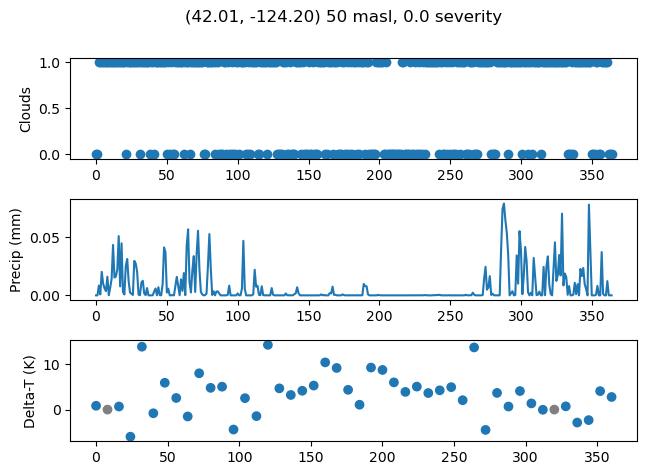

In [5]:
def plot_one_feature(feature):
    xax_365 = np.arange(0, 365)
    xax_46  = np.arange(0, 46) * 8
    
    fig, ax = plt.subplots(nrows=3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    ax[0].scatter(xax_365, feature["is_cloudy"])
    ax[0].set_ylabel("Clouds")
    
    ax[1].plot(xax_365, feature["prcp"])
    ax[1].set_ylabel("Precip (mm)")
    
    ax[2].scatter(xax_46, feature["dT"], c=np.where(feature["dT"] == 0, "gray", "#1f77b4"))
    ax[2].set_ylabel("Delta-T (K)")
    
    fig.suptitle("({:4.2f}, {:4.2f}) {} masl, {} severity".format(
        feature["latitude"][0], feature["longitude"][0], feature["elevation"][0], feature["SEVERITY"][0]
    )) 
    
    plt.show()

plot_one_feature(feature)